# Bayesian MaxEnt (BME) reweighting

This is an example showing the steps involved in the reweighting procedure described in the example "Combining NMR data with MD simulation of RNA". In this example we will show how to:
1. Format the data to be read by the BME software
2. Perform a preliminary reweighing and understand the output of the procedure
3. Cross-validate the results
4. Select the paramter $\theta$
5. Give a structural interpretation of the weights


## 1. Data collection ##
We first need a set of experimental data and associated uncertainties. In this example, we have a set of $m=26$  scalar couplings measured for an RNA tetranucleotide with sequence CCCC. Data is taken from [here](https://pubs.acs.org/doi/10.1021/bi3010347) and are stored in the file `../data/couplings_exp.dat`

In [1]:
 %cat ../data/couplings_exp.dat 

# DATA=JCOUPLINGS PRIOR=GAUSS
C1-H1H2  1.0  1.5
C1-H2H3  3.6  1.5
C1-H3H4  8.7  1.5
C1-H3P   8.8  1.5
C2-H1H2  1.0  1.5
C2-H2H3  4.3  1.5
C2-1H5H4 1.0  1.5
C2-2H5H4 1.0  1.5
C2-1H5P  3.8  1.5
C2-2H5P  1.2  1.5
C2-H3P   9.3  1.5
C3-H1H2  1.0  1.5
C3-H2H3  4.7  1.5
C3-H3H4  8.8  1.5
C3-1H5H4 2.1  1.5
C3-2H5H4 1.0  1.5
C3-1H5P  3.9  1.5
C3-2H5P  0.5  1.5
C3-H3P   9.3  1.5
C4-H1H2  2.6  1.5
C4-H2H3  4.9  1.5
C4-H3H4  7.2  1.5
C4-1H5H4 2.0  1.5
C4-2H5H4 1.4  1.5
C4-1H5P  3.8  1.5
C4-2H5P  1.1  1.5

The first line is an header, defining the type of data and the error model. In column 1 we have a user-defined label, that in this case specify the residue index and the pair of hydrogen atoms for which the scalar coupling was measured. Experimental average and uncertainty are in column 2 and 3, respectively. In this case the scalar coupling is measured in Hz, but the unit is not relevant as long as they are all consistent in the experimental and calculated data file. 

The corresponding calculated datafile `../data/couplings_calc.dat` has 27 columns (the first being a label, and then one column per experimental average). The number of rows depends on the simulation lenght and stride. In this case, we have 20000 frames.

Scalar couplings were back-calculated using our software [barnaba](https://github.com/srnas/barnaba). The user has the freedom of choosing his/her favourite forward model. For proteins, different tools exists for calculating NMR obesvables from structures, including [MDTRAJ](http://mdtraj.org/1.6.2/analysis.html#nmr-observables), [PLUMED](https://plumed.github.io/doc-v2.4/user-doc/html/_i_s_d_b_colvar.html), [ConSENSx](http://consensx.itk.ppke.hu/) and others. 

In [2]:
%cat ../data/couplings_calc.dat | head -2

       0  6.8070e-03  2.5228e+00  8.6578e+00  4.3340e+00  1.1298e+01  5.6601e+00  2.3890e+00  8.0543e-01  2.9443e+00  1.8871e+00  1.0280e+01  1.6735e-01  5.0689e+00  1.0466e+01  5.0832e-01  2.8702e+00  5.7233e+00  9.9341e-01  3.7443e+00  1.0452e+01  7.0422e+00  2.1905e+00  2.0937e+00  1.0219e+00  2.5474e+00  2.2108e+00 
       1  2.8348e-02  3.3641e+00  1.1031e+01  6.2590e+00  9.5890e+00  5.2667e+00  1.0391e-01  3.8126e+00  1.5808e+00  3.4192e+00  1.0102e+01  9.4165e-01  4.7987e+00  8.3268e+00  1.7008e+00  1.3560e+00  4.4549e+00  1.1512e+00  5.1500e+00  8.1667e-02  5.3870e+00  7.5786e+00  2.1276e+00  9.9560e-01  2.4387e+00  2.3124e+00 
cat: stdout: Broken pipe


To understand what is going on, we can plot the experimental and calculated averages. We first define a plotting function that we will also use later. 

In [3]:
# import libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# import numpy
import numpy as np
# define plotting function. 
def plot(f1,f2,wopt=[],w=None,power=None):

    # define figure size
    fig, ax = plt.subplots(1,1,figsize=(10,8))
    # read experimental averages and errors
    exp_data = np.array([[float(x) for x in line.split()[1:]] for line in open(f1) if "#" not in line])
    # read labels
    labels = [line.split()[0] for line in open(f1) if "#" not in line]
    # read back-calculated data 
    calc_data = np.array([[float(x) for x in line.split()[1:]] for line in open(f2) if "#" not in line])
    
    # sort by magnitude to make the plot nicer
    idxs = np.argsort(exp_data[:,0])
    xx = range(len(idxs))
    
    # plot experimental data
    plt.errorbar(xx,exp_data[idxs,0],yerr=exp_data[idxs,1],fmt="o",label="Exp",c='gray')
    # if power is specified, treat as NOE 
    if(power!=None):
        avg = np.average(np.power(calc_data[:,idxs],-power),axis=0,weights=w)
        plt.scatter(xx,np.power(avg,-1./power),label = "MD")
    else:
        plt.scatter(xx,np.average(calc_data[:,idxs],axis=0,weights=w),label = "MD")
    # optionally use weights
    if(len(wopt)!=0):
        if(power!=None):
            avg = np.average(np.power(calc_data[:,idxs],-power),axis=0,weights=wopt)
            plt.scatter(xx,np.power(avg,-1./power),label = "MD reweighted")
        else:
            plt.scatter(xx,np.average(calc_data[:,idxs],axis=0,weights=wopt),label = "MD, reweighted")
    # set legend
    plt.legend(loc=2)
    # set xticks 
    nl = [labels[i] for i in idxs]
    plt.xticks(xx,nl,rotation=90)
    return labels, exp_data, calc_data


26


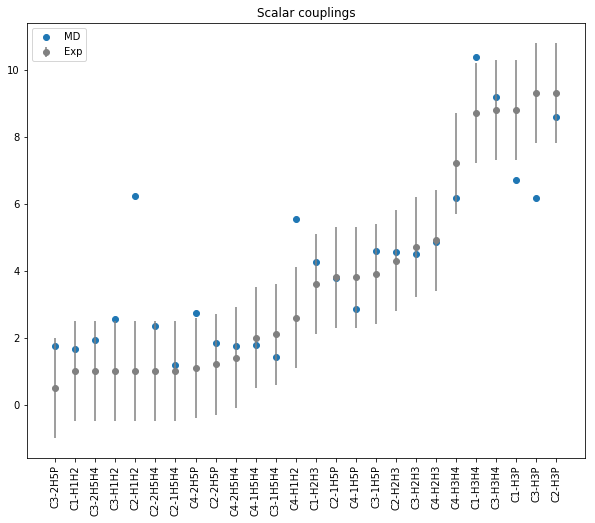

In [4]:
# define name of files                                                                               
exp_couplings = '../data/couplings_exp.dat'
calc_couplings = '../data/couplings_calc.dat'

# plot data
labels, exp_data, calc_data = plot(exp_couplings,calc_couplings)
print len(labels)
plt.title("Scalar couplings")
plt.show()

We can clearly see that few calculated averages do not match the experimental value. We can take a closer look at one of them in particular (C2-H1H2) that seems to be significantly off. More precisely, we plot the histogram and average calculated from simulation, together with the experimental value. 


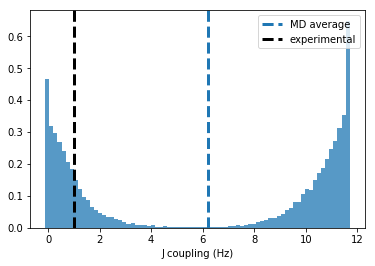

In [5]:
# find index corresponding to the desired coupling
idx = labels.index("C2-H1H2")
# plot the histogram
plt.hist(calc_data[:,idx],bins=75,density=True,alpha=0.75)
# make vertical bar corresponding to the MD average
plt.axvline(np.average(calc_data[:,idx]),label="MD average",ls="--",lw=3)
# make vertical bar corresponding to the MD average
plt.axvline(exp_data[idx,0],c='k',label="experimental",ls="--",lw=3)
plt.xlabel("J coupling (Hz)")
plt.legend()
plt.show()



## 2. BME reweighting ##

We here show how to apply the BME reweighting procedure. Essentially, there are only three fundamental steps:
1. Initialize the class 
2. Load the data. Multiple data can be also loaded (see next example)
3. Optimize

In the example below we match all 26 scalar couplings data described above. Theta is set to 2 for the moment being, the procedure and code to find viable values for theta are shown below.


In [6]:
# import modules
import sys
import os

# this is a trick to get the parent directory 
directory_to_bme = os.getcwd()[:-8]
sys.path.append(directory_to_bme)
import bme_reweight as bme

# initialize reweighting class                                                                                                                                
rew = bme.Reweight()

# load data                                                                                      
rew.load(exp_couplings,calc_couplings)

# do optimization using theta=2                                                                                                                               
chi2_before,chi2_after, srel = rew.optimize(theta=2)

print "# CHI2 before minimization:     %8.4f" % (chi2_before)
print "# CHI2 after minimization:      %8.4f" % (chi2_after)
print "# Fraction of effective frames: %8.4f" % (np.exp(srel))


# Warning: expt average              C3-2H5P=5.0000e-01 is smaller than minimum value in simulation 9.9199e-01
# exp data: (26, 2)
# calc data: (20000, 26)
# CHI2 before minimization:       1.1525
# CHI2 after minimization:        0.1785
# Fraction of effective frames:   0.3742


The chi2 drops from 1.15 to 0.18. Let's take a closer look at the data, to be sure that the averages calculated using the new weights are indeed getting better:

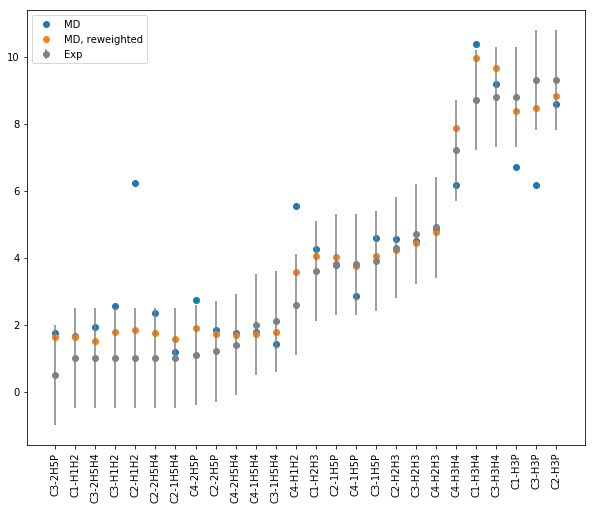

In [7]:
# returns the optimized weights
w_opt = rew.get_weights()

# feed the weights to plotting function
plot(exp_couplings,calc_couplings,wopt=w_opt)
plt.show()

Super. Now all the data are within experimental uncertainty. Let's see what happened to the distributions of couplings in C2-H1H2

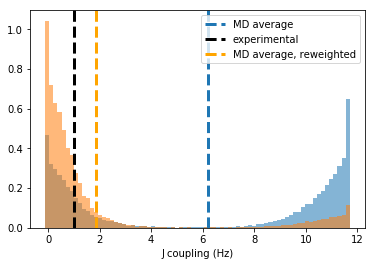

In [8]:
# find index corresponding to the desired coupling
idx = labels.index("C2-H1H2")
# plot the histogram
plt.hist(calc_data[:,idx],bins=75,density=True,alpha=0.55)
# make vertical bar corresponding to the MD average
plt.axvline(np.average(calc_data[:,idx]),label="MD average",ls="--",lw=3)
# make vertical bar corresponding to the MD average
plt.axvline(exp_data[idx,0],c='k',label="experimental",ls="--",lw=3)

# plot the histogram with the new weights
plt.hist(calc_data[:,idx],bins=75,density=True,alpha=0.55,weights=w_opt)
# make vertical bar corresponding to the MD average
plt.axvline(np.average(calc_data[:,idx],weights=w_opt),label="MD average, reweighted",ls="--",lw=3,c='orange')

plt.xlabel("J coupling (Hz)")
plt.legend()
plt.show()

Note also that a warning is issued when loading the data:

 ```
 Warning: expt average C3-2H5P=0.5000     is smaller than minimum value in simulation 0.9920 
 ```
 
 This happens when the experimental average is smaller (larger) than the minimum (maximum) value in simulation. This might point to a problem with convergence or errors in the data. 
 

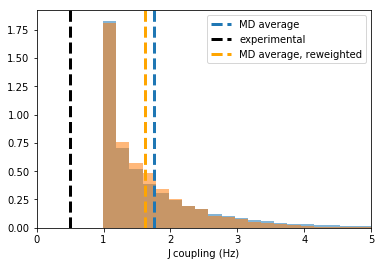

In [9]:
# find index corresponding to the desired coupling
idx = labels.index("C3-2H5P")
# plot the histogram
plt.hist(calc_data[:,idx],bins=75,density=True,alpha=0.55)
# make vertical bar corresponding to the MD average
plt.axvline(np.average(calc_data[:,idx]),label="MD average",ls="--",lw=3)
# make vertical bar corresponding to the MD average
plt.axvline(exp_data[idx,0],c='k',label="experimental",ls="--",lw=3)

# plot the histogram with the new weights
plt.hist(calc_data[:,idx],bins=75,density=True,alpha=0.55,weights=w_opt)
# make vertical bar corresponding to the MD average
plt.axvline(np.average(calc_data[:,idx],weights=w_opt),label="MD average, reweighted",ls="--",lw=3,c='orange')

plt.xlabel("J coupling (Hz)")
plt.legend()
plt.xlim(0,5)
plt.show()

What happens here is that the experimental value could not be matched perfectly. The Karplus relationship has a minimum value of ~1Hz, and hence the experimental value of 0.5Hz could never be reached. 

## 3. Cross-validation ## 

One fundamental step to assess the validity of the procedure is to cross validate the results. We can easily check this by comparing against experimental NOE data that were not used in the optimization.
Essentially, what we do is that we use the original and new weights to calculate the agreement with NOE data.
If the agreement gets worse, it might be because a. we are overfitting or b. Data are inconsistent.

If the data are formatted properly, we can check the agreement by using the function `weight_exp()`, as shown below

In [10]:
exp_noe = '../data/noe_exp.dat'
calc_noe = '../data/noe_calc.dat'
chi2_noe_before, chi2_noe_after = rew.weight_exp(exp_noe,calc_noe,"my_first_example")
print "# NOE CHI2 before minimization: %8.4f" % (chi2_noe_before)
print "# NOE CHI2 after minimization:  %8.4f" % (chi2_noe_after)

# NOE CHI2 before minimization:   3.1469
# NOE CHI2 after minimization:    1.3226


This function writes on the disk a file `my_first_example.stats.dat` that can be easily interpreted:

In [11]:
%cat my_first_example.stats.dat | head

# noe_exp.dat vs. noe_calc.dat srel=-9.8289e-01
#  Label             avg exp sigma exp avg before avg after 
   C1_1H2'_C2_H1'  1.796e-04 1.024e-04 5.278e-05 1.314e-04  4.210e+00 4.000e-01 5.163e+00 4.435e+00 
   C1_1H2'_C2_1H5' 1.988e-03 6.769e-04 1.188e-03 3.259e-03  2.820e+00 1.600e-01 3.073e+00 2.597e+00 
   C1_H5_C2_H5     3.374e-04 1.496e-04 1.684e-04 4.467e-04  3.790e+00 2.800e-01 4.255e+00 3.617e+00 
   C1_H6_C1_H1'    5.828e-04 2.224e-04 6.414e-04 6.645e-04  3.460e+00 2.200e-01 3.405e+00 3.385e+00 
   C1_H6_C1_1H2'   6.707e-04 2.619e-04 7.123e-04 6.836e-04  3.380e+00 2.200e-01 3.346e+00 3.369e+00 
   C1_H6_C2_H5     4.160e-04 1.705e-04 1.757e-04 4.589e-04  3.660e+00 2.500e-01 4.225e+00 3.601e+00 
   C2_H5_C1_1H2'   1.323e-04 8.781e-05 1.131e-04 1.938e-04  4.430e+00 4.900e-01 4.547e+00 4.157e+00 
   C2_H5_C3_H5     3.321e-04 1.468e-04 3.164e-04 7.003e-04  3.800e+00 2.800e-01 3.831e+00 3.356e+00 


For NOEs, the output is written both in distance as well as in 1/power units. The fact that enforcing the agreement with scalar couplings makes the agreement with NOE better is a good sign. Now let's plot the NOEs with the old and new weights:

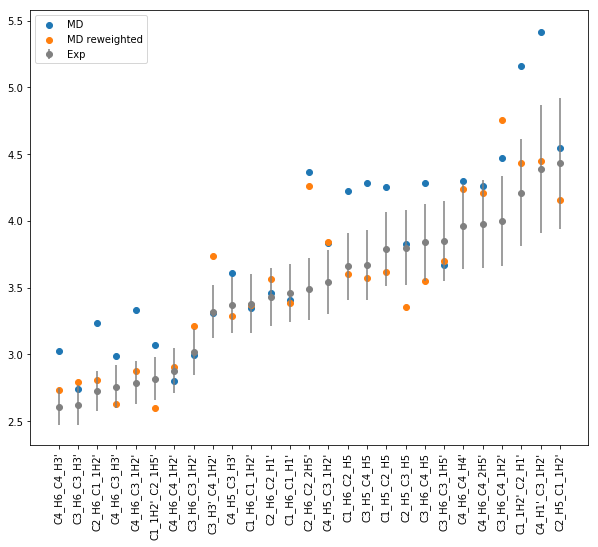

In [12]:
plot(exp_noe,calc_noe,wopt=w_opt,power=6)
plt.show()

# 4. $\theta$ selection #

So far we have set the free parameter $\theta=2$ without justification. Setting $\theta$ can be sometimes tricky, and we show in this section how to find a viable value for this parameter. Essentially, we scan different values and plot $\chi^2$ versus the fraction of effective frames ($N_{eff} = exp(S_{rel})$).

Note that below we repeat part of the code defined above, this is just to make it easier for users to copy-paste the correct lines of code. 


In [13]:
#this is a trick to get the parent directory 
directory_to_bme = os.getcwd()[:-8]
sys.path.append(directory_to_bme)
import bme_reweight as bme

# define name of files                                                                               
exp_couplings = '../data/couplings_exp.dat'
calc_couplings = '../data/couplings_calc.dat'
exp_noe = '../data/noe_exp.dat'
calc_noe = '../data/noe_calc.dat'

# initialize reweighting class                                                                                                                                
rew = bme.Reweight()

# load data                                                                                      
rew.load(exp_couplings,calc_couplings)

# do minimization for different values of theta
thetas= [0.1,0.5,1,2,3,4,5,7.5,10,15,20,40,50,100,500,5000]
results = []
for t in thetas:
    # do the minimization
    chi2_jc_before,chi2_jc_after, srel = rew.optimize(theta=t)
    # calculate agreement with NOE, and write output to a temporary file
    chi2_noe_before,chi2_noe_after = rew.weight_exp(exp_noe,calc_noe,"tmp")
    results.append( [np.exp(srel),chi2_jc_before,chi2_jc_after,chi2_noe_before,chi2_noe_after])
    


# Warning: expt average              C3-2H5P=5.0000e-01 is smaller than minimum value in simulation 9.9199e-01
# exp data: (26, 2)
# calc data: (20000, 26)
# exp data: (26, 2)
# calc data: (20000, 26)
# exp data: (26, 2)
# calc data: (20000, 26)
# exp data: (26, 2)
# calc data: (20000, 26)
# exp data: (26, 2)
# calc data: (20000, 26)
# exp data: (26, 2)
# calc data: (20000, 26)
# exp data: (26, 2)
# calc data: (20000, 26)
# exp data: (26, 2)
# calc data: (20000, 26)
# exp data: (26, 2)
# calc data: (20000, 26)
# exp data: (26, 2)
# calc data: (20000, 26)
# exp data: (26, 2)
# calc data: (20000, 26)
# exp data: (26, 2)
# calc data: (20000, 26)
# exp data: (26, 2)
# calc data: (20000, 26)
# exp data: (26, 2)
# calc data: (20000, 26)
# exp data: (26, 2)
# calc data: (20000, 26)
# exp data: (26, 2)
# calc data: (20000, 26)


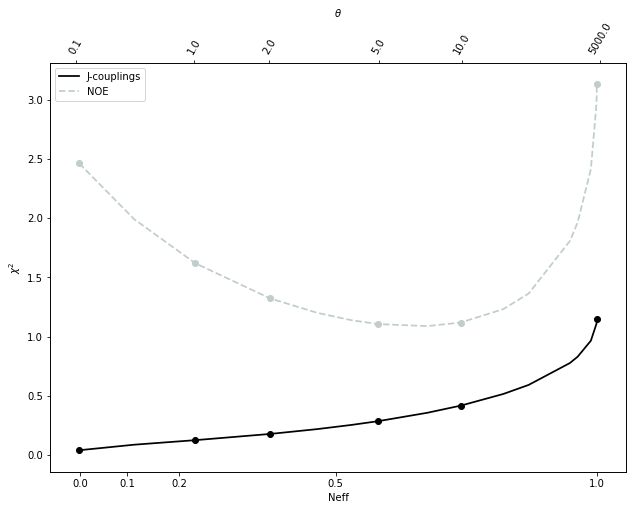

In [14]:
#handling tickers in logspace is a abit painful
from matplotlib.ticker import NullFormatter
from matplotlib import ticker

results = np.array(results)
# define the figure
fig, ax1 = plt.subplots(figsize=(10, 8))
plt.subplots_adjust(left=0.15, right=0.95, top=0.83, bottom=0.12)
# plot j couplings
ax1.plot(results[:,0],results[:,2],label="J-couplings",c='k',lw=1.75)
# plot NOE
ax1.plot(results[:,0],results[:,4],label="NOE",c='#C1CDCD',ls="--",lw=1.75)
# set tickers
ax1.set_xticks([0.01,0.1,0.2,0.5,1.0])
ax1.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter("%3.1f"))
ax1.xaxis.set_minor_formatter(ticker.NullFormatter())

# now make a new axis just to show the theta values
ax2 = ax1.twiny()
ax2.plot(results[:,0],results[:,2],c='w',lw=0.01)

# draw ticks at selected theta
sele = [0.1,1,2,5,10,5000]
iis = [thetas.index(s) for s in  sele]
ax2.set_xticks(results[iis,0])
ax2.set_xticklabels(["%.1f"% s for s in sele],rotation=60)
ax1.scatter(results[iis,0],results[iis,4],c='#C1CDCD')
ax1.scatter(results[iis,0],results[iis,2],c='k')

ax1.set_xlabel("Neff")
ax2.set_xlabel(r"$\theta$")
ax1.set_ylabel(r"$\chi^2$")
ax1.legend()

Based on the plot above, one would choose a $\theta=5$ or $\theta=10$, as there is a clear minimum around this value for the NOE $\chi^2$. In our example we have used $\theta=2$ to show more clearly the effects of the reweighting technique. More generally, it is often useful to assess the robustness of the results on small changes in $\theta$ 

## 5. Structural interpretation ##
Now that we have new weights it is very easy to calculate any average/distribution of interest. 
For example, we can calculate the distance from a reference, A-form structure. 
For doing this we need to analyse the trajectory. Here, we use [barnaba](https://github.com/srnas/barnaba) and MDTRAJ, but one can use the her/his own favourite analysis software. 

To start with, we calculate the rmsd from A-form. As we can see below, the effect of the reweighting is to promote the presence of structures closer to A-form.

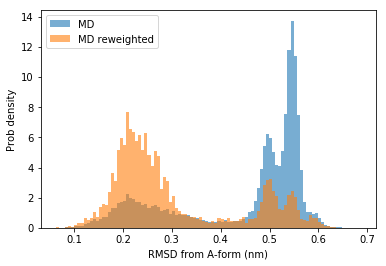

In [15]:
import mdtraj as md

traj = md.load("../data/traj_CCCC_OPC_300.dcd",top="../data/CCCCh.pdb")
ref = md.load("../data/CCCCh.pdb")

rmsds = md.rmsd(traj,ref)
plt.hist(rmsds,bins=100,alpha=0.6,density=True,label="MD")
plt.hist(rmsds,bins=100,alpha=0.6,weights=w_opt,density=True,label="MD reweighted")
plt.legend()
plt.xlabel("RMSD from A-form (nm)")
plt.ylabel("Prob density")
plt.show()


Distances, torsion angle distributions or radius of gyration (below) and any other quantities can be calculated.


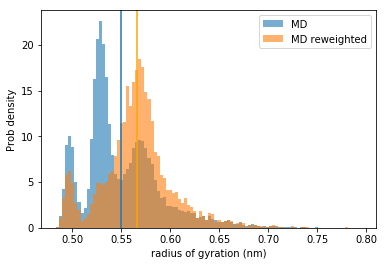

In [16]:
# compute radius of gyration
rg = md.compute_rg(traj)

# make histogram of original simulation
plt.hist(rg,bins=100,alpha=0.6,density=True,label="MD")
# draw vertical line indicating the average
plt.axvline(np.average(rg))
# do the same with the new weights
plt.hist(rg,bins=100,alpha=0.6,weights=w_opt,density=True,label="MD reweighted")
plt.axvline(np.average(rg,weights=w_opt),c='orange')
# legend and labels
plt.legend()
plt.xlabel("radius of gyration (nm)")
plt.ylabel("Prob density")
plt.show()

In our eperience, it is often useful to use metrics different from RMSD in nucleic acids. Here, we use the eRMSD, a structural distance that considers the orientation and positions of nucleobases.

# Loaded reference ../data/CCCCh.pdb 
# Loaded target ../data/traj_CCCC_OPC_300.dcd 


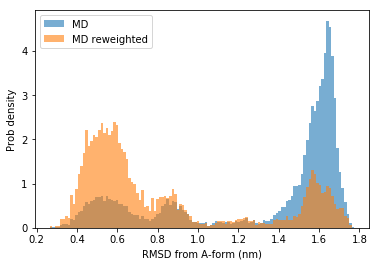

In [17]:
import barnaba as bb
ermsd = bb.ermsd("../data/CCCCh.pdb","../data/traj_CCCC_OPC_300.dcd",topology="../data/CCCCh.pdb")
plt.hist(ermsd,bins=120,alpha=0.6,density=True,label="MD")
plt.hist(ermsd,bins=120,alpha=0.6,weights=w_opt,density=True,label="MD reweighted")
plt.legend()
plt.xlabel("RMSD from A-form (nm)")
plt.ylabel("Prob density")
plt.show()

Although with weights it is possible to extract all kinds of information, it is also possible to generate an ensemble of structures by extracting frames with the desired probability. Below, we take 100 frames and save them to a new trajectory. 


In [18]:
# choose 100 samples
ff = np.random.choice(len(w_opt),size=100,p=w_opt,replace=False)

# save the frames to trajectory
traj[ff].save("new_trajectory.dcd")




Based on the eRMSD histogram, we can perform a primitive clustering, and separate structures according to their eRMSD value:


In [19]:
#now save in three separate files, according to the eRMSD value: this corresponds to a primitive clustering
aa = []
bb = []
cc = []
for f in ff:
    if(ermsd[f]<0.75):
        aa.append(f)
    elif(ermsd[f]<1.0):
        bb.append(f)
    else:
        cc.append(f)
        
traj[aa].save("new_trajectory_aa.dcd")  
traj[bb].save("new_trajectory_bb.dcd")
traj[cc].save("new_trajectory_cc.dcd")

We show below the three clusters, corresponding to the A-form (first peak) 
<img src="vmdscene_aa.png" width="300">
C1/C3 unstacked (second peak)
<img src="vmdscene_bb.png" width="300">
Intercalated (third peak)
<img src="vmdscene_cc.png" width="300">